In [16]:
import torch
from torch import nn
from torch.nn import functional as F
from collections import OrderedDict
from copy import deepcopy
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import random
from tqdm import tqdm
import seaborn as sns
import os



In [17]:
class Linear5(nn.Module):
    def __init__(self, in_feature=2, hidden_features=5, num_classes=4):
        super(Linear5, self).__init__()
        self.fc1 = nn.Linear(in_features=in_feature, out_features=hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features, out_features=hidden_features)
        self.bn2 = nn.BatchNorm1d(hidden_features)
        self.fc3 = nn.Linear(in_features=hidden_features, out_features=hidden_features)
        self.bn3 = nn.BatchNorm1d(hidden_features)
        self.fc4 = nn.Linear(in_features=hidden_features, out_features=hidden_features)
        self.bn4 = nn.BatchNorm1d(hidden_features)
        self.fc5 = nn.Linear(in_features=hidden_features, out_features=num_classes)

    def forward(self,x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        return F.log_softmax(self.fc5(x), 1)

    def get_activations(self, x):
        act = {"pre":OrderedDict(), "post":OrderedDict()}
        act["pre"]["fc1"] = deepcopy(x.clone().detach().cpu().numpy())
        x = self.fc1(x)
        act["post"]["fc1"] = deepcopy(x.clone().detach().cpu().numpy())
        x = F.relu(self.bn1(x))
        act["pre"]["fc2"] = deepcopy(x.clone().detach().cpu().numpy())
        x = self.fc2(x)
        act["post"]["fc2"] = deepcopy(x.clone().detach().cpu().numpy())
        x = F.relu(self.bn2(x))
        act["pre"]["fc3"] = deepcopy(x.clone().detach().cpu().numpy())
        x = self.fc3(x)
        act["post"]["fc3"] = deepcopy(x.clone().detach().cpu().numpy())
        x = F.relu(self.bn3(x))
        act["pre"]["fc4"] = deepcopy(x.clone().detach().cpu().numpy())
        x = self.fc4(x)
        act["post"]["fc4"] = deepcopy(x.clone().detach().cpu().numpy())
        x = F.relu(self.bn4(x))
        act["pre"]["fc5"] = deepcopy(x.clone().detach().cpu().numpy())
        x = self.fc5(x)
        act["post"]["fc5"] = deepcopy(x.clone().detach().cpu().numpy())
        return act

    def project_weights(self, projection_mat_dict):
        self.fc1.weight.data = torch.mm(projection_mat_dict["post"]["fc1"].transpose(0,1), torch.mm(self.fc1.weight.data, projection_mat_dict["pre"]["fc1"].transpose(0,1)))
        self.fc1.bias.data = torch.mm(self.fc1.bias.data.unsqueeze(0), projection_mat_dict["post"]["fc1"]).squeeze(0)

        self.fc2.weight.data = torch.mm(projection_mat_dict["post"]["fc2"].transpose(0,1), torch.mm(self.fc2.weight.data, projection_mat_dict["pre"]["fc2"].transpose(0,1)))
        self.fc2.bias.data = torch.mm(self.fc2.bias.data.unsqueeze(0), projection_mat_dict["post"]["fc2"]).squeeze(0)

        self.fc3.weight.data = torch.mm(projection_mat_dict["post"]["fc3"].transpose(0,1), torch.mm(self.fc3.weight.data, projection_mat_dict["pre"]["fc3"].transpose(0,1)))
        self.fc3.bias.data = torch.mm(self.fc3.bias.data.unsqueeze(0), projection_mat_dict["post"]["fc3"]).squeeze(0)

        self.fc4.weight.data = torch.mm(projection_mat_dict["post"]["fc4"].transpose(0,1), torch.mm(self.fc4.weight.data, projection_mat_dict["pre"]["fc4"].transpose(0,1)))
        self.fc4.bias.data = torch.mm(self.fc4.bias.data.unsqueeze(0), projection_mat_dict["post"]["fc4"]).squeeze(0)

        self.fc5.weight.data =  torch.mm(self.fc5.weight.data, projection_mat_dict["pre"]["fc5"].transpose(0,1))
        return




In [18]:
def get_dataset(train_samples_per_class, test_samples_per_class, std = 0.5):
    # print("-"*40)
    # print("Generating Dataset")
    # print("-"*40)
    means = [(1.0,1.0),(-1.0,1.0), (-1.0,-1.0), (1.0,-1.0) ]
    std_dev = (std,std)
    data_list = []
    target_list = []
    for classes in range(4):
        for sample in tqdm(range(train_samples_per_class), desc=f"Train class {classes}"):
            data_list.append(torch.normal(mean= torch.tensor(means[classes]), std= torch.tensor(std_dev) ))
            target_list.append(torch.tensor(classes).long())
    data_tensor = torch.stack(data_list, 0)
    target_tensor = torch.stack(target_list, 0)
    train_data = (data_tensor, target_tensor)

    data_list = []
    target_list = []
    for classes in range(4):
        for sample in tqdm(range(test_samples_per_class), desc=f"Test class {classes}"):
            data_list.append(torch.normal(mean= torch.tensor(means[classes]), std= torch.tensor(std) ))
            target_list.append(torch.tensor(classes).long())
    data_tensor = torch.stack(data_list, 0)
    target_tensor = torch.stack(target_list, 0)
    test_data = (data_tensor, target_tensor)
    return train_data, test_data




In [19]:
def train(model, train_loader, device, optimizer, schedular):
    model.train()
    total_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        log_prob = model(data)
        loss = F.nll_loss(log_prob, target)
        total_loss+= loss.detach().item()/len(train_loader.dataset)
        loss.backward()
        optimizer.step()
        schedular.step(loss)
    return total_loss


def test(model, test_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        log_prob = model(data)
        pred = log_prob.argmax(dim=1, keepdim=True)
        loss = F.nll_loss(log_prob, target)
        total_loss+= loss.detach().item()/len(test_loader.dataset)
        correct += pred.eq(target.view_as(pred)).sum().item()
    acc = 100*correct/len(test_loader.dataset)
    return total_loss, acc



In [20]:
def plot_decision_boundary(model, data, device, title):
    data_list = []
    # x_points = np.arange(-4,4.04,0.05)
    # y_points = np.arange(4,-4.04,-0.05)
    x_points = np.arange(-3,3.04,0.01)
    y_points = np.arange(3,-3.04,-0.01)
    for x in x_points:
        for y in y_points:
            data_list.append(torch.tensor( (x,y) ) )
    data_tensor = torch.stack(data_list).to(device).float()
    predicted_class = model(data_tensor).argmax(dim=1).long()

    # color_lookup = [torch.tensor([1.0, 0.0, 0.0]).to(device),
    #                 torch.tensor([0.5294, 0.8078, 0.9216]).to(device),
    #                 torch.tensor([0.5647, 0.9333, 0.5647]).to(device),
    #                 torch.tensor([0.5, 0.5, 0.5]).to(device)]


    color_lookup = [torch.tensor([1.0, 0.8, 0.8]).to(device), # light
                    torch.tensor([0.8, 1.0, 0.8]).to(device), # light
                    torch.tensor([0.8, 0.8, 1.0]).to(device), # light
                    torch.tensor([0.5, 0.5, 0.5]).to(device), # light
                    torch.tensor([1.0, 0.0, 0.0]).to(device),
                    torch.tensor([0.0, 1.0, 0.0]).to(device),
                    torch.tensor([0.0, 0.0, 1.0]).to(device),
                    torch.tensor([0.0, 0.0, 0.0]).to(device),
                    ]
    ind = 0
    decision_boundary = torch.zeros( (3, x_points.shape[0], y_points.shape[0])).to(device)
    for x, _ in enumerate(x_points):
        for y, _ in enumerate(y_points):
            decision_boundary[:, x, y ] = color_lookup[predicted_class[ind]]
            ind+=1

    # draw circles.
    for i in range(data[0].shape[0]):
        x = data[0][i]
        y = data[1][i]
        x_i = np.round(x[0]/0.01).long()+300
        y_i = 601 - (np.round(x[1]/0.01).long()+300) # top left is  0 0  for image!
        for j in range(x_i-1, x_i+2):### To increase boldness
            for k in range(y_i-1, y_i+2):
                if j<=601 and k<=601:
                    decision_boundary[:, j, k] =  color_lookup[4+y]

    decision_boundary = (255 * decision_boundary).long().permute(2,1,0).cpu().numpy().astype(np.uint8)
    fig,ax = plt.subplots()
    fig.set_size_inches(10,8)
    plt.style.use("seaborn-talk")
    cs = sns.color_palette("muted")

    plt.imshow( decision_boundary)
    x_ticks_positions = np.arange(0, x_points.shape[0]+0.5, 200)
    x_ticks_labels = [str(x) for x in np.arange(-3,3.04,2.0)]
    plt.xticks(x_ticks_positions, x_ticks_labels, fontsize=30)
    y_ticks_positions = np.arange(0, y_points.shape[0]+0.5, 150 )
    y_ticks_labels = [str(x) for x in np.arange(3,-3.04,-1.5)]
    plt.yticks(y_ticks_positions, y_ticks_labels, fontsize=30)
    plt.xlabel("Feature 1", fontsize=40)
    plt.ylabel("Feature 2", fontsize=40)
    # plt.title(title)
    # plt.xticks()
    # plt.yticks(fontsize=30)
    plt.tight_layout()
    plt.savefig(f"./images/demo_{title.split(':')[0].lower()}.pdf")
    plt.show()
    return




In [21]:

seed=42
std = 0.5
epochs = 10
train_samples_per_class = 10000
test_samples_per_class = 1000
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if not os.path.exists("./images"):
    os.makedirs("./images")
# torch.use_deterministic_algorithms(True)
device = "cuda"
data1, data2 = get_dataset(train_samples_per_class, test_samples_per_class, std = std)
kwargs = {
  'batch_size': 2048,
  'num_workers': 1,
  'pin_memory': True,
  'shuffle': True
}
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data1[0], data1[1]),**kwargs)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data2[0], data2[1]), **kwargs)
retain_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data1[0][train_samples_per_class:], data1[1][train_samples_per_class:]),**kwargs)
forget_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data1[0][:train_samples_per_class], data1[1][:train_samples_per_class]),**kwargs)
test_retain_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data2[0][test_samples_per_class:], data2[1][test_samples_per_class:]),**kwargs)
test_forget_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data2[0][:test_samples_per_class], data2[1][:test_samples_per_class]),**kwargs)


# Plot data
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


Test class 3: 100%|██████████| 1000/1000 [00:00<00:00, 16485.55it/s]


<ipython-input-24-be7e2cb3f660>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-talk")


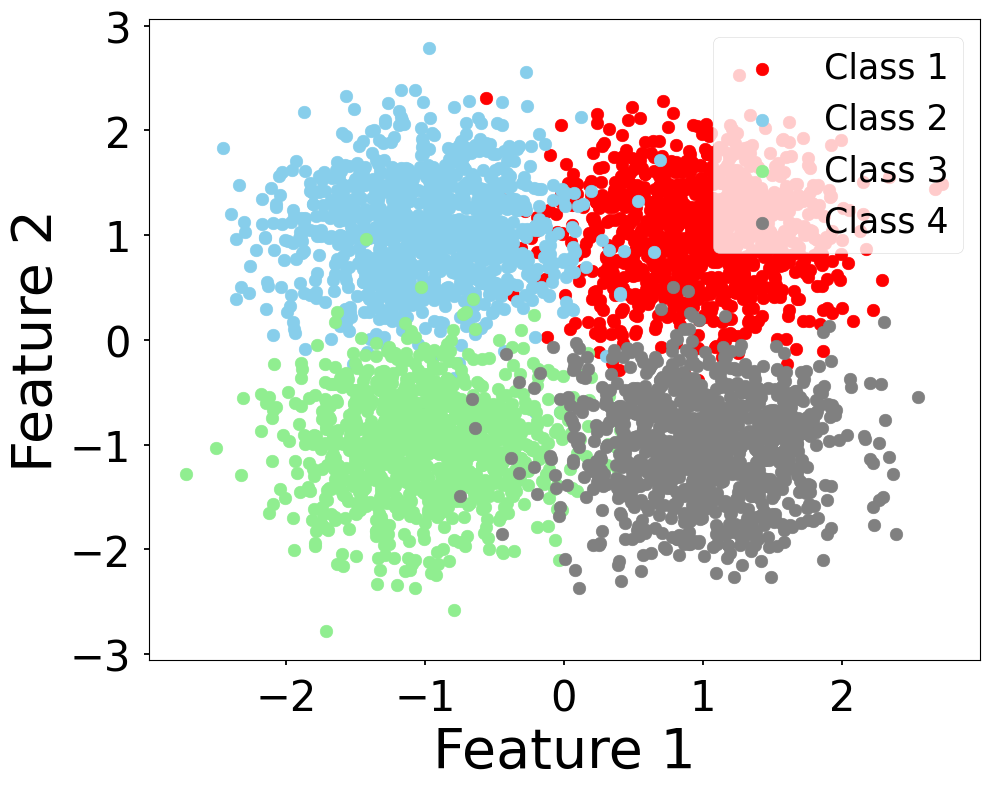

In [24]:
fig, ax=plt.subplots()
fig.set_size_inches(10,8)
plt.style.use("seaborn-talk")
cs = sns.color_palette("muted")
# plt.imshow(decision_boundary)
plt.scatter(data2[0][:test_samples_per_class,0], data2[0][:test_samples_per_class,1],color= lighten_color("r",1.0),label="Class 1")
plt.scatter(data2[0][test_samples_per_class:2*test_samples_per_class,0], data2[0][test_samples_per_class:2*test_samples_per_class,1], color= lighten_color("skyblue",1.0),label="Class 2")
plt.scatter(data2[0][2*test_samples_per_class:3*test_samples_per_class,0],  data2[0][2*test_samples_per_class:3*test_samples_per_class,1], color= lighten_color("lightgreen",1.0),label="Class 3")
plt.scatter(data2[0][3*test_samples_per_class:,0],  data2[0][3*test_samples_per_class:,1], color= "gray",label="Class 4")
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("Feature 1", fontsize=40)
plt.ylabel("Feature 2", fontsize=40)
plt.legend( fontsize=25)
plt.tight_layout()
plt.savefig(f"./images/demo_data.pdf")
plt.show()


----------------------------------------
Training
----------------------------------------


100%|██████████| 20/20 [00:00<00:00, 27.15it/s]


Epoch 1: Train Loss 0.0004 Test Loss 0.0002 Test Acc 93.17


100%|██████████| 20/20 [00:00<00:00, 28.33it/s]


Epoch 2: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.67


100%|██████████| 20/20 [00:00<00:00, 29.80it/s]


Epoch 3: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.65


100%|██████████| 20/20 [00:00<00:00, 26.39it/s]


Epoch 4: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.65


100%|██████████| 20/20 [00:00<00:00, 20.61it/s]


Epoch 5: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.78


100%|██████████| 20/20 [00:01<00:00, 19.53it/s]


Epoch 6: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.83


100%|██████████| 20/20 [00:00<00:00, 28.59it/s]


Epoch 7: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.88


100%|██████████| 20/20 [00:00<00:00, 23.26it/s]


Epoch 8: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.88


100%|██████████| 20/20 [00:00<00:00, 27.63it/s]


Epoch 9: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.75


100%|██████████| 20/20 [00:00<00:00, 29.26it/s]


Epoch 10: Train Loss 0.0001 Test Loss 0.0001 Test Acc 95.78
Test Baseline- retain acc 95.83 forget acc 95.60 metric 0.0422


<ipython-input-20-c4a103af780e>:49: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-talk")


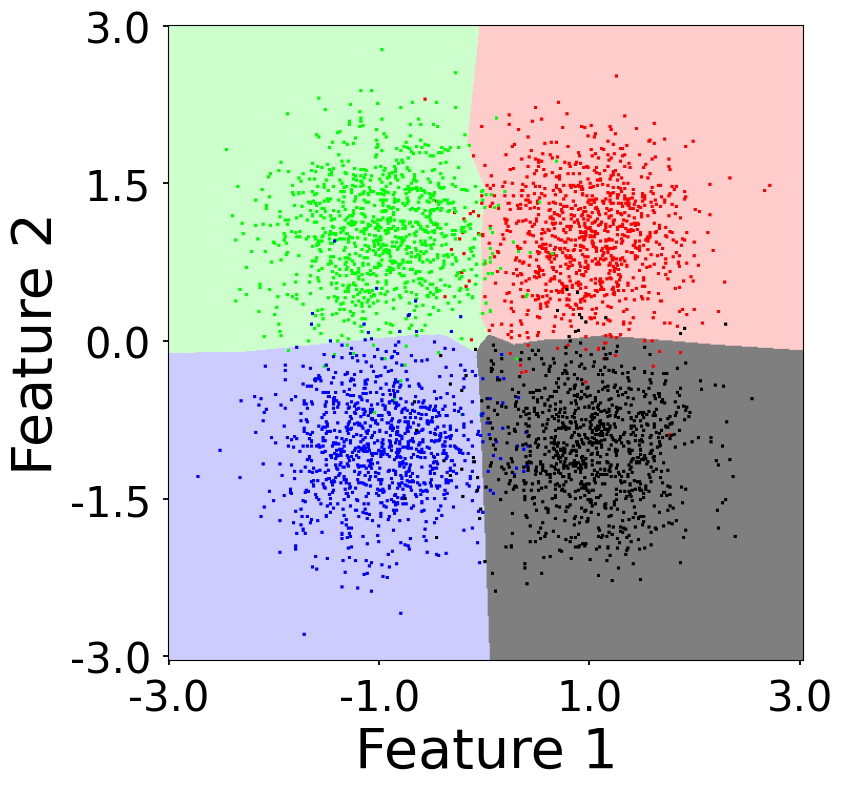

100%|██████████| 15/15 [00:00<00:00, 43.54it/s]


Test Retained- retain acc 97.33 forget acc 0.00 metric 0.9733


<ipython-input-20-c4a103af780e>:49: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-talk")


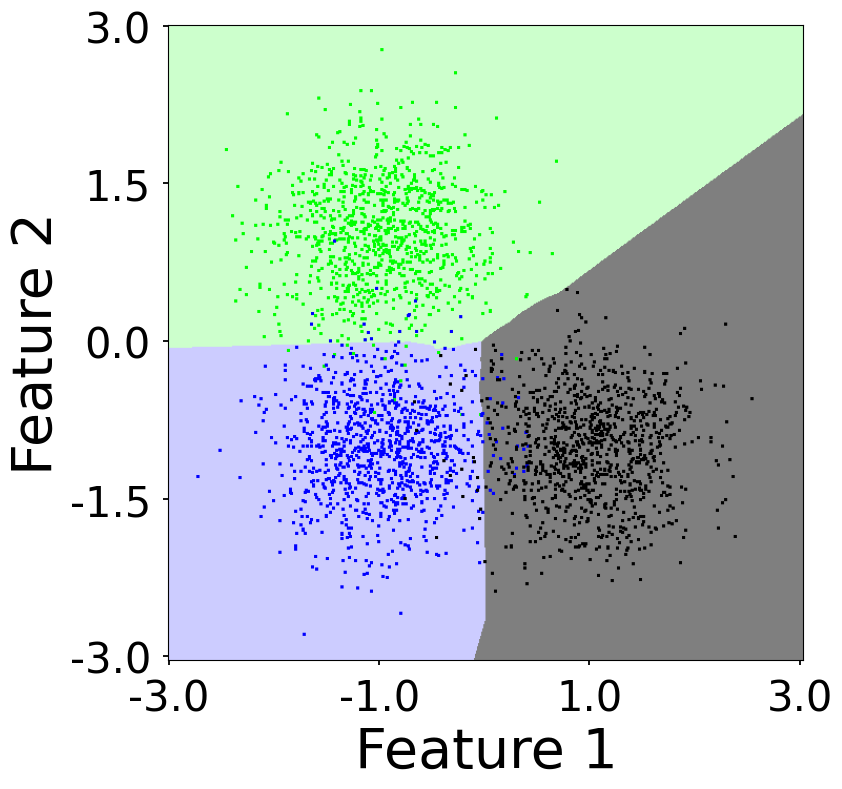

In [25]:

print("-"*40)
print("Training")
print("-"*40)
model = Linear5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.7)
for epoch in range(1, epochs+1):
    train_loss = train(model, train_loader, device, optimizer, scheduler)
    test_loss, test_acc = test(model, test_loader, device)
    print(f"Epoch {epoch}: Train Loss {train_loss:.4f} Test Loss {test_loss:.4f} Test Acc {test_acc:.2f}")
test_retain_loss, test_retain_acc = test(model, test_retain_loader, device)
test_forget_loss, test_forget_acc = test(model, test_forget_loader, device)
test_metric = test_retain_acc*(100-test_forget_acc)/10000
# print("-"*40)
print(f"Test Baseline- retain acc {test_retain_acc:.2f} forget acc {test_forget_acc:.2f} metric {test_metric:.4f}")
# print("-"*40)
plot_decision_boundary(model, data2, device, title = f"Baseline: Retain acc-{test_retain_acc:.2f} Forget Acc-{test_forget_acc:.2f}" )

# print("-"*40)
# print("Retrain")
# print("-"*40)
retrained_model = Linear5().to(device)
optimizer = torch.optim.SGD(retrained_model.parameters(), lr = 0.1, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.7)
for epoch in range(1, epochs+1):
    train_loss = train(retrained_model, retain_loader, device, optimizer, scheduler)
    test_loss, test_acc = test(retrained_model, test_retain_loader, device)
    # print(f"Epoch {epoch}: Train Loss {train_loss:.4f} Test Loss {test_loss:.4f} Test Acc {test_acc:.2f}")
test_retain_loss, test_retain_acc = test(retrained_model, test_retain_loader, device)
test_forget_loss, test_forget_acc = test(retrained_model, test_forget_loader, device)
test_metric = test_retain_acc*(100-test_forget_acc)/10000
# print("-"*40)
print(f"Test Retained- retain acc {test_retain_acc:.2f} forget acc {test_forget_acc:.2f} metric {test_metric:.4f}")
# print("-"*40)
plot_decision_boundary(retrained_model, (data2[0][test_samples_per_class:], data2[1][test_samples_per_class:]), device, title = f"Retrained: Retain acc-{test_retain_acc:.2f} Forget Acc-{test_forget_acc:.2f}" )




retain_data = data1[0][train_samples_per_class:]
model.eval()
retain_act = model.get_activations(retain_data.to(device))
retain_mat_dict= {"pre":OrderedDict(), "post":OrderedDict()}
retain_normalize_var_mat_dict = {"pre":OrderedDict(), "post":OrderedDict()}


In [27]:
# Compute Ur
for loc in retain_act.keys():
    for key in retain_act[loc].keys():
        activation = torch.Tensor(retain_act[loc][key]).to("cuda").transpose(0,1)
        U,S,Vh = torch.linalg.svd(activation, full_matrices=False)
        U = U.cpu().numpy()
        S = S.cpu().numpy()
        retain_mat_dict[loc][key] = U
        retain_normalize_var_mat_dict[loc][key] = S**2 / (S**2).sum()

forget_data = data1[0][:train_samples_per_class]
forget_act = model.get_activations(forget_data.to(device))
forget_mat_dict= {"pre":OrderedDict(), "post":OrderedDict()}
forget_normalize_var_mat_dict = {"pre":OrderedDict(), "post":OrderedDict()}
# Compute Uf
for loc in forget_act.keys():
    for key in forget_act[loc].keys():
        activation = torch.Tensor(forget_act[loc][key]).to("cuda").transpose(0,1)
        U,S,Vh = torch.linalg.svd(activation, full_matrices=False)
        U = U.cpu().numpy()
        S = S.cpu().numpy()
        forget_mat_dict[loc][key] = U
        forget_normalize_var_mat_dict[loc][key] = S**2 / (S**2).sum()



In [28]:
# print("-"*40)
print("Forgetting Search for best alpha_f and alpha_r on Train Set.")
# print("-"*40)
base_retain_loss, base_retain_acc = test(model, retain_loader, device)
base_forget_loss, base_forget_acc = test(model, forget_loader, device)
base_metric = base_retain_acc*(100-base_forget_acc)/10000
print(f"Train Baseline - retain acc {base_retain_acc:.2f} forget acc {base_forget_acc:.2f} metric {base_metric:.4f}")
best_alpha_r = 1.0
best_alpha_f = 0.25
best_metric = base_metric


Forgetting Search for best alpha_f and alpha_r on Train Set.
Train Baseline - retain acc 95.34 forget acc 95.50 metric 0.0429


In [30]:
proj_mat_dict= {"pre":OrderedDict(), "post":OrderedDict()}
for alpha_r in [1, 3, 10, 30, 100, 300, 1000]:
    for alpha_f in [0.25, 0.5, 0.9, 1, 3, 10, 30, 100, 300, 1000]:
        for loc in retain_act.keys():
            for key in retain_act[loc].keys():
                sqrt_imp_r = torch.diag(torch.tensor( (alpha_r*retain_normalize_var_mat_dict[loc][key]/(( (alpha_r-1)*retain_normalize_var_mat_dict[loc][key]) +1))**0.5).to(device))
                Ur = torch.tensor(retain_mat_dict[loc][key]).to(device)
                Ur = torch.mm(Ur, sqrt_imp_r)
                Mr = torch.mm(Ur, Ur.transpose(0,1))
                sqrt_imp_f = torch.diag(torch.tensor( (alpha_f*forget_normalize_var_mat_dict[loc][key]/(( (alpha_f-1)*forget_normalize_var_mat_dict[loc][key]) +1))**0.5).to(device))
                Uf = torch.tensor(forget_mat_dict[loc][key]).to(device)
                Uf = torch.mm(Uf, sqrt_imp_f)
                Mf = torch.mm(Uf, Uf.transpose(0,1))
                I = torch.eye(Mf.shape[0]).to(device)
                if loc == "pre":
                    proj_mat_dict[loc][key]= I - Mf  + torch.mm(Mf, Mr)
                else:
                    proj_mat_dict[loc][key]= I
        inference_model = deepcopy(model)
        inference_model.project_weights(proj_mat_dict)
        retain_loss, retain_acc = test(inference_model, retain_loader, device)
        forget_loss, forget_acc = test(inference_model, forget_loader, device)
        metric = retain_acc*(100-forget_acc)/10000
        if metric>best_metric:
            best_metric = metric
            best_alpha_r = alpha_r
            best_alpha_f = alpha_f
            print(f"Current Search - retain acc {retain_acc:.2f} forget acc {forget_acc:.2f} metric {best_metric:.4f} alpha_r {best_alpha_r} alpha_f {best_alpha_f} ")


# Plot decision boundary for best model
for loc in retain_act.keys():
    for key in retain_act[loc].keys():
        sqrt_imp_r = torch.diag(torch.tensor( (best_alpha_r*retain_normalize_var_mat_dict[loc][key]/(( (best_alpha_r-1)*retain_normalize_var_mat_dict[loc][key]) +1))**0.5).to(device))
        Ur = torch.tensor(retain_mat_dict[loc][key]).to(device)
        Ur = torch.mm(Ur, sqrt_imp_r)
        Mr = torch.mm(Ur, Ur.transpose(0,1))
        sqrt_imp_f = torch.diag(torch.tensor( (best_alpha_f*forget_normalize_var_mat_dict[loc][key]/(( (best_alpha_f-1)*forget_normalize_var_mat_dict[loc][key]) +1))**0.5).to(device))
        Uf = torch.tensor(forget_mat_dict[loc][key]).to(device)
        Uf = torch.mm(Uf, sqrt_imp_f)
        Mf = torch.mm(Uf, Uf.transpose(0,1))
        I = torch.eye(Mf.shape[0]).to(device)
        if loc == "pre":
            proj_mat_dict[loc][key]= I - Mf + torch.mm(Mf, Mr)
        else:
            proj_mat_dict[loc][key]= I

inference_model = deepcopy(model)
inference_model.project_weights(proj_mat_dict)
test_retain_loss, test_retain_acc = test(inference_model, test_retain_loader, device)
test_forget_loss, test_forget_acc = test(inference_model, test_forget_loader, device)
test_metric = test_retain_acc*(100-test_forget_acc)/10000
print(f"Test Unlearnt- retain acc {test_retain_acc:.2f} forget acc {test_forget_acc:.2f} metric {test_metric:.4f}")



Test Unlearnt- retain acc 97.43 forget acc 0.00 metric 0.9743


<ipython-input-20-c4a103af780e>:49: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-talk")


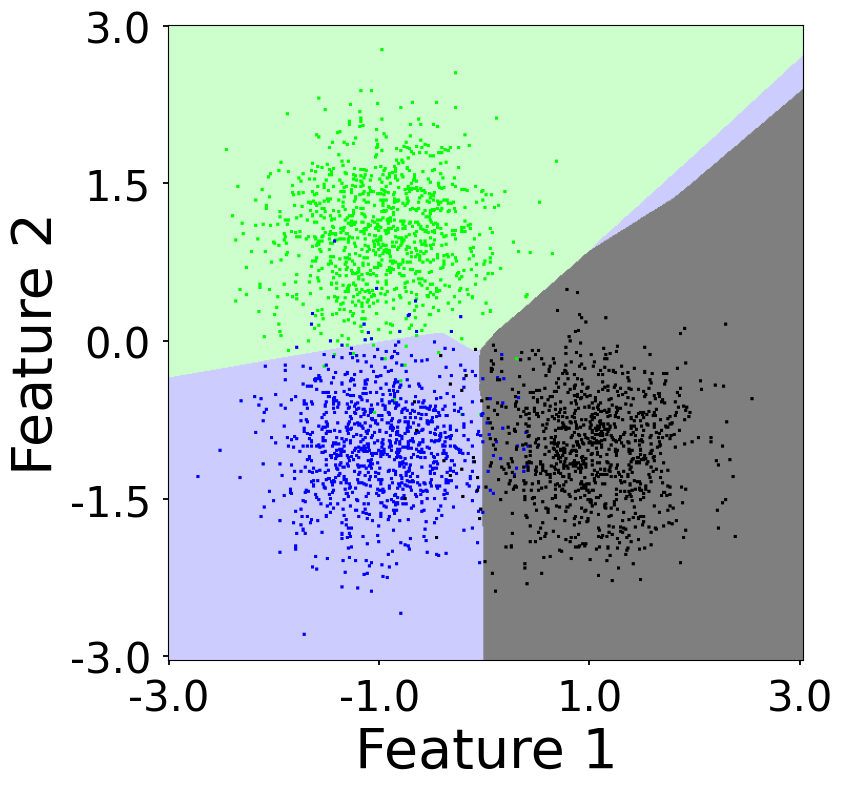

In [31]:
# print("-"*40)
plot_decision_boundary(inference_model, (data2[0][test_samples_per_class:], data2[1][test_samples_per_class:]), device, title = f"Unlearnt: Retain acc-{test_retain_acc:.2f} Forget Acc-{test_forget_acc:.2f}" )